In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import integrate
from scipy.integrate import solve_ivp
from numpy import diff
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)

C:\Users\DANIEL\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
params = {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

In [3]:
def funciones(xi,y, sigma, n, h):
    psi0_,eta_,psi01_,eta1_ = y
    dydxi = [h*(eta_ + sigma*xi**(3)*psi0_**(n+1))*((1 - n*sigma) + (n+1)*sigma*psi0_)/xi/(2*(n+1)*sigma*eta_ - xi)
           ,xi**(2)*psi0_**(n)*(1 - n*sigma + n*sigma*psi0_) 
           ,h*(((eta1_ + 3*sigma*xi**(2)*psi0_**(n+1) + sigma*xi**(3)*(n+1)*psi0_**(n)*psi01_)*((1 - n*sigma) + (n + 1)*sigma*psi0_)/xi/(2*(n+1)*sigma*eta_ - xi)) + (sigma*(n+1)*psi01_)*(eta_ + sigma*xi**(3)*psi0_**(n+1))/xi/(2*(n+1)*sigma*eta_ - xi)  -  (((1 - n*sigma) + (n + 1)*sigma*psi0_)*(eta_ + sigma*xi**(3)*psi0_**(n+1))/xi**(2)/(2*(n+1)*sigma*eta_ - xi) )  -  (((1 - n*sigma) + (n + 1)*sigma*psi0_)*(eta_ + sigma*xi**(3)*psi0_**(n+1))*(2*(n+1)*sigma*eta1_ - 1)/xi/((2*(n+1)*sigma*eta_ - xi)**(2))))         
           ,(2*xi*psi0_**(n) + n*xi**(2)*psi0_**(n-1)*psi01_)*(1 - n*sigma + n*sigma* psi0_) + xi**(2)*psi0_**(n)*n*sigma*psi01_]
    return dydxi

In [4]:
c = 2.997*10**(8)          # Velocidad de la luz en S.I.
G = 6.673*10**(-11)        # Constante de gravitación universal en S.I.
Msun = 1.989*10**(30)      # Masa solar en S.I.

In [5]:
C_inicial = 0                    
C_final =  1/4                  
Paso_C = 1/16                   
Num_C = round((Paso_C + C_final - C_inicial)/Paso_C) 
Lista_C = np.linspace(C_inicial,C_final,Num_C)
print('intervalo de C: ',end='')                                                    
print(*Lista_C, sep=', ')

n_inicial = 0.5              
n_final = 4.0
Paso_n = 0.5
Numn = round((Paso_n + n_final - n_inicial)/Paso_n)
Lista_n = np.linspace(n_inicial,n_final,Numn)
print('intervalo de n: ',end='')                                                    
print(*Lista_n, sep=', ')

rho_c = 1.5*10**(18)

sigma_m = 0.3

sigma_inicial = 0.1                  
sigma_final = 0.9
Paso_sigma = 0.025
NumSigma = round((Paso_sigma + sigma_final - sigma_inicial)/Paso_sigma)
Lista_sigma = np.linspace(sigma_inicial,sigma_final,NumSigma)
print('intervalo de \u03c3: ',end='')                                                    
print(*Lista_sigma, sep=', ')

Numero_de_modelos = len(Lista_C)*len(Lista_n)*len(Lista_sigma)
print('Número de modelos: ',Numero_de_modelos)

intervalo de C: 0.0, 0.0625, 0.125, 0.1875, 0.25
intervalo de n: 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0
intervalo de σ: 0.1, 0.125, 0.15000000000000002, 0.17500000000000002, 0.2, 0.225, 0.25, 0.275, 0.30000000000000004, 0.325, 0.35, 0.375, 0.4, 0.42500000000000004, 0.45000000000000007, 0.475, 0.5, 0.525, 0.55, 0.5750000000000001, 0.6, 0.625, 0.65, 0.675, 0.7000000000000001, 0.725, 0.75, 0.775, 0.8, 0.8250000000000001, 0.85, 0.875, 0.9
Número de modelos:  1320


In [6]:
Lista_M = []                       # Contenedor para la masa total M
Lista_R = []                       # Contenedor para el radio total R
Lista_Rho_c = []                   # Contenedor para las densidades centrales
Lista_sigma_m = []

# Espacio en el que se almacenarán los modelos

for i in range(len(Lista_n)):      
    
    Lista_M.append([])
    Lista_R.append([])
    Lista_Rho_c.append([])
    Lista_sigma_m.append([])
    
    for j in range(len(Lista_C)):
        
        Lista_M[i].append([])
        Lista_R[i].append([])
        Lista_Rho_c[i].append([])
        Lista_sigma_m[i].append([])        

In [7]:
%%time

contador = 0

for i in range(len(Lista_n)):
    
    n = Lista_n[i]
    
    K = sigma_m*c**(2)/rho_c**(1/n)    
    
    for j in range(len(Lista_C)):
        
        C = Lista_C[j]
        
        h = 1 - 2*C
        
        for k in range(len(Lista_sigma)): 
        
            sigma = Lista_sigma[k]
            
            rho_cen = (c**(2)*sigma/K)**(n)/1000
            
            # Condiciones iniciales
            Psi0 = 1.0
            Eta0 = 0.0
            Psi10 = 0.0
            Eta10 = 0.0
            
            y0 = [Psi0,Eta0,Psi10,Eta10]
            
            def stop_condition(xi,y,sigma,n,h):
                return y[0] - 10**-15
            
            stop_condition.terminal = True
            
            xi0 = 10**(-14)
            ximax = 10000
    
            xi_span = (xi0,ximax)
            
    
            soluciones = solve_ivp(funciones,xi_span,y0,method='RK45',events=stop_condition,
                           args=(sigma,n,h))
        
            if soluciones.status == 0:
                print ("insuficiente intervalo de integración xi. Parámetros: ",
                      'C = {}, '.format(C),'n = {}, '.format(n),'\u03c3 = {}'.format(sigma))
                contador = contador + 1
                continue
            else:
                Psi = soluciones.y[0]
                Eta = soluciones.y[1]
                Psi1 = soluciones.y[2]
                Eta1 = soluciones.y[3]
                xi = soluciones.t
                    
    #############################################################################################################################
            # Xi normalizada
            xiNorm = xi/xi[-1]
            
            # Presión entre presión central
            PNorm = Psi**(n+1)
            
            m = (c**(2)*sigma*(n+1)/(4*np.pi*rho_c)**(1/3)/G)**(3/2)*Eta/Msun   # Masa en unidades de masa solar
            r = (c**(2)*sigma*(n+1)/4/np.pi/G/rho_c)**(1/2)*xi/1000             # Radio en kilómetros
            
            R = (c**(2)*(n+1)/4/np.pi/G)**(1/2)*(K/c**(2))**(n/2)*sigma**((1-n)/2)*xi[-1]/1000         # Radio en kilómetros
            M = (c**(2)*(n+1)/(4*np.pi)**(1/3)/G)**(3/2)*(K/c**(2))**(n/2)*sigma**((3-n)/2)*Eta[-1]/Msun  # Masa en unidades de masa solar
         
            Lista_Rho_c[i][j].append(rho_cen)
            Lista_M[i][j].append(M)
            Lista_R[i][j].append(R)
            Lista_sigma_m [i][j].append(sigma)
            
print('Número de modelos no integrables: ',contador,' de ', Numero_de_modelos)

C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 1.5,  σ = 0.675
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 1.5,  σ = 0.7000000000000001
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 1.5,  σ = 0.725
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 1.5,  σ = 0.75
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 1.5,  σ = 0.775
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 1.5,  σ = 0.8
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 1.5,  σ = 0.8250000000000001
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 1.5,  σ = 0.85
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 1.5,  σ = 0.875
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 1.5,  σ = 0.9
insuficiente intervalo de integración xi. Parámetros:  C = 0.0625,  n = 1.5,  σ = 0.675
insuficiente intervalo de integración xi. 

insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.0,  σ = 0.5
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.0,  σ = 0.525
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.0,  σ = 0.55
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.0,  σ = 0.5750000000000001
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.0,  σ = 0.6
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.0,  σ = 0.625
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.0,  σ = 0.65
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.0,  σ = 0.675
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.0,  σ = 0.7000000000000001
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.0,  σ = 0.725
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.0,  σ = 0.75
insuficiente 

insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.5,  σ = 0.4
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.5,  σ = 0.42500000000000004
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.5,  σ = 0.45000000000000007
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.5,  σ = 0.475
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.5,  σ = 0.5
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.5,  σ = 0.525
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.5,  σ = 0.55
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.5,  σ = 0.5750000000000001
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.5,  σ = 0.6
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.5,  σ = 0.625
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 2.5,  σ = 0.65

insuficiente intervalo de integración xi. Parámetros:  C = 0.125,  n = 3.0,  σ = 0.875
insuficiente intervalo de integración xi. Parámetros:  C = 0.125,  n = 3.0,  σ = 0.9
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 3.0,  σ = 0.30000000000000004
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 3.0,  σ = 0.325
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 3.0,  σ = 0.35
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 3.0,  σ = 0.375
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 3.0,  σ = 0.4
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 3.0,  σ = 0.42500000000000004
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 3.0,  σ = 0.45000000000000007
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 3.0,  σ = 0.475
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 3.0,  σ = 0.5

insuficiente intervalo de integración xi. Parámetros:  C = 0.0625,  n = 3.5,  σ = 0.775
insuficiente intervalo de integración xi. Parámetros:  C = 0.0625,  n = 3.5,  σ = 0.8
insuficiente intervalo de integración xi. Parámetros:  C = 0.0625,  n = 3.5,  σ = 0.8250000000000001
insuficiente intervalo de integración xi. Parámetros:  C = 0.0625,  n = 3.5,  σ = 0.85
insuficiente intervalo de integración xi. Parámetros:  C = 0.0625,  n = 3.5,  σ = 0.875
insuficiente intervalo de integración xi. Parámetros:  C = 0.0625,  n = 3.5,  σ = 0.9
insuficiente intervalo de integración xi. Parámetros:  C = 0.125,  n = 3.5,  σ = 0.125
insuficiente intervalo de integración xi. Parámetros:  C = 0.125,  n = 3.5,  σ = 0.225
insuficiente intervalo de integración xi. Parámetros:  C = 0.125,  n = 3.5,  σ = 0.25
insuficiente intervalo de integración xi. Parámetros:  C = 0.125,  n = 3.5,  σ = 0.275
insuficiente intervalo de integración xi. Parámetros:  C = 0.125,  n = 3.5,  σ = 0.30000000000000004
insuficiente int

insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 4.0,  σ = 0.125
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 4.0,  σ = 0.15000000000000002
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 4.0,  σ = 0.17500000000000002
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 4.0,  σ = 0.2
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 4.0,  σ = 0.225
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 4.0,  σ = 0.25
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 4.0,  σ = 0.275
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 4.0,  σ = 0.30000000000000004
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 4.0,  σ = 0.325
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 4.0,  σ = 0.35
insuficiente intervalo de integración xi. Parámetros:  C = 0.0,  n = 4.0,  σ = 0.375
insuficiente intervalo de i

insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 4.0,  σ = 0.375
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 4.0,  σ = 0.4
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 4.0,  σ = 0.42500000000000004
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 4.0,  σ = 0.45000000000000007
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 4.0,  σ = 0.475
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 4.0,  σ = 0.5
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 4.0,  σ = 0.525
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 4.0,  σ = 0.55
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 4.0,  σ = 0.5750000000000001
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 4.0,  σ = 0.6
insuficiente intervalo de integración xi. Parámetros:  C = 0.1875,  n = 4.0,  σ = 0.62

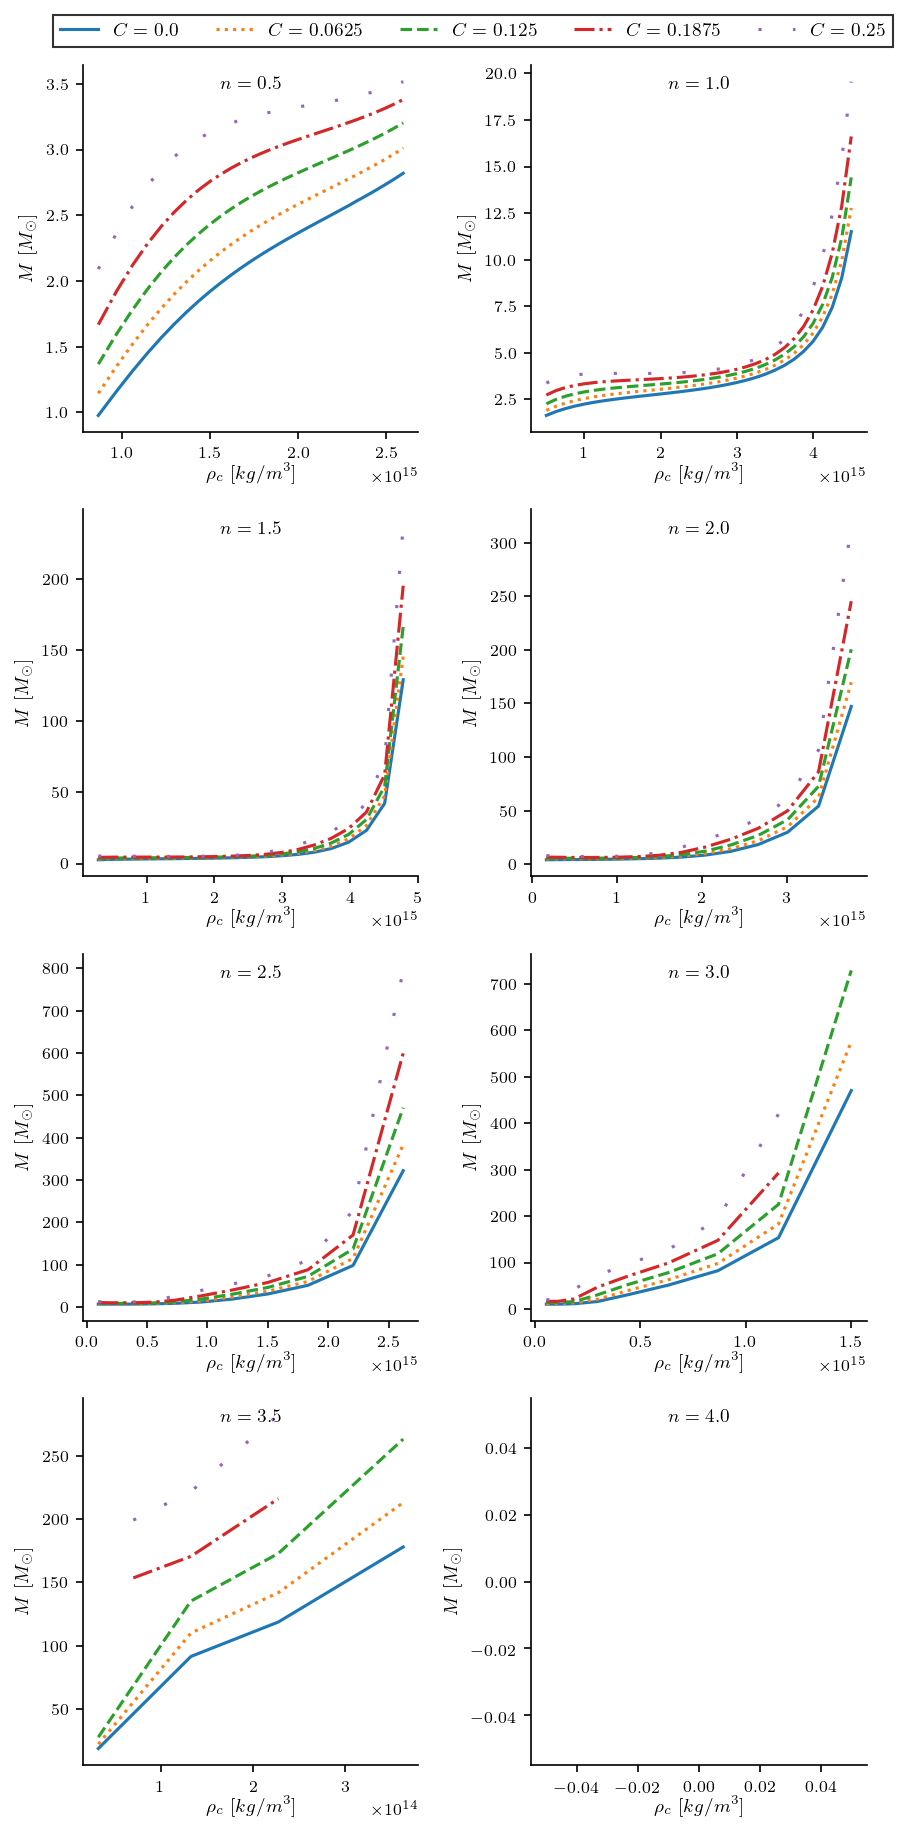

In [8]:
LineStyles = ['solid', 'dotted', 'dashed', 'dashdot', (0,(1,10)), (0,(5,10)), (0,(3,10,1,10)), (0,(3,1,1,1,1,1)),
              'dotted', 'dashed', 'dashdot', (0,(1,10)), (0,(5,10))]

axes = ()
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(6,12),dpi=150)


for j in range(len(Lista_C)):
    
    axes[0][0].plot(Lista_Rho_c[0][j],Lista_M[0][j],linestyle=LineStyles[j],label=r'$C = {}$'.format(Lista_C[j]))
    axes[0][1].plot(Lista_Rho_c[1][j],Lista_M[1][j],linestyle=LineStyles[j])
    axes[1][0].plot(Lista_Rho_c[2][j],Lista_M[2][j],linestyle=LineStyles[j])
    axes[1][1].plot(Lista_Rho_c[3][j],Lista_M[3][j],linestyle=LineStyles[j])
    axes[2][0].plot(Lista_Rho_c[4][j],Lista_M[4][j],linestyle=LineStyles[j])
    axes[2][1].plot(Lista_Rho_c[5][j],Lista_M[5][j],linestyle=LineStyles[j])
    axes[3][0].plot(Lista_Rho_c[6][j],Lista_M[6][j],linestyle=LineStyles[j])
    axes[3][1].plot(Lista_Rho_c[7][j],Lista_M[7][j],linestyle=LineStyles[j])
    
axes[0][0].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[0][0].set_ylabel(r'$M \, \, [M_{\odot}]$',fontsize=9)
axes[0][0].xaxis.set_label_coords(0.5,-0.0875)
axes[0][0].set_title(r'$n = %.1f$'%(Lista_n[0]),x=0.5,y=0.9,fontsize=9)
axes[0][0].spines['right'].set_color('none')
axes[0][0].spines['top'].set_color('none')
axes[0][0].legend(ncol=5, loc=(-0.09,1.05),fontsize=9,edgecolor='k',fancybox=False)

axes[0][1].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[0][1].set_ylabel(r'$M \, \, [M_{\odot}]$',fontsize=9)
axes[0][1].xaxis.set_label_coords(0.5,-0.0875)
axes[0][1].set_title(r'$n = %.1f$'%(Lista_n[1]),x=0.5,y=0.9,fontsize=9)
axes[0][1].spines['right'].set_color('none')
axes[0][1].spines['top'].set_color('none')

axes[1][0].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[1][0].set_ylabel(r'$M \, \, [M_{\odot}]$',fontsize=9)
axes[1][0].xaxis.set_label_coords(0.5, -0.0875)
axes[1][0].set_title(r'$n = %.1f$'%(Lista_n[2]),x=0.5,y=0.9,fontsize=9)
axes[1][0].spines['right'].set_color('none')
axes[1][0].spines['top'].set_color('none')

axes[1][1].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[1][1].set_ylabel(r'$M \, \, [M_{\odot}]$',fontsize=9)
axes[1][1].xaxis.set_label_coords(0.5, -0.0875)
axes[1][1].set_title(r'$n = %.1f$'%(Lista_n[3]),x=0.5,y=0.9,fontsize=9)
axes[1][1].spines['right'].set_color('none')
axes[1][1].spines['top'].set_color('none')

axes[2][0].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[2][0].set_ylabel(r'$M \, \, [M_{\odot}]$',fontsize=9)
axes[2][0].xaxis.set_label_coords(0.5, -0.0875)
axes[2][0].set_title(r'$n = %.1f$'%(Lista_n[4]),x=0.5,y=0.9,fontsize=9)
axes[2][0].spines['right'].set_color('none')
axes[2][0].spines['top'].set_color('none')

axes[2][1].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[2][1].set_ylabel(r'$M \, \, [M_{\odot}]$',fontsize=9)
axes[2][1].xaxis.set_label_coords(0.5, -0.0875)
axes[2][1].set_title(r'$n = %.1f$'%(Lista_n[5]),x=0.5,y=0.9,fontsize=9)
axes[2][1].spines['right'].set_color('none')
axes[2][1].spines['top'].set_color('none')

axes[3][0].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[3][0].set_ylabel(r'$M \, \, [M_{\odot}]$',fontsize=9)
axes[3][0].xaxis.set_label_coords(0.5, -0.0875)
axes[3][0].set_title(r'$n = %.1f$'%(Lista_n[6]),x=0.5,y=0.9,fontsize=9)
axes[3][0].spines['right'].set_color('none')
axes[3][0].spines['top'].set_color('none')

axes[3][1].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[3][1].set_ylabel(r'$M \, \, [M_{\odot}]$',fontsize=9)
axes[3][1].xaxis.set_label_coords(0.5, -0.0875)
axes[3][1].set_title(r'$n = %.1f$'%(Lista_n[7]),x=0.5,y=0.9,fontsize=9)
axes[3][1].spines['right'].set_color('none')
axes[3][1].spines['top'].set_color('none')

fig.tight_layout()


plt.show()

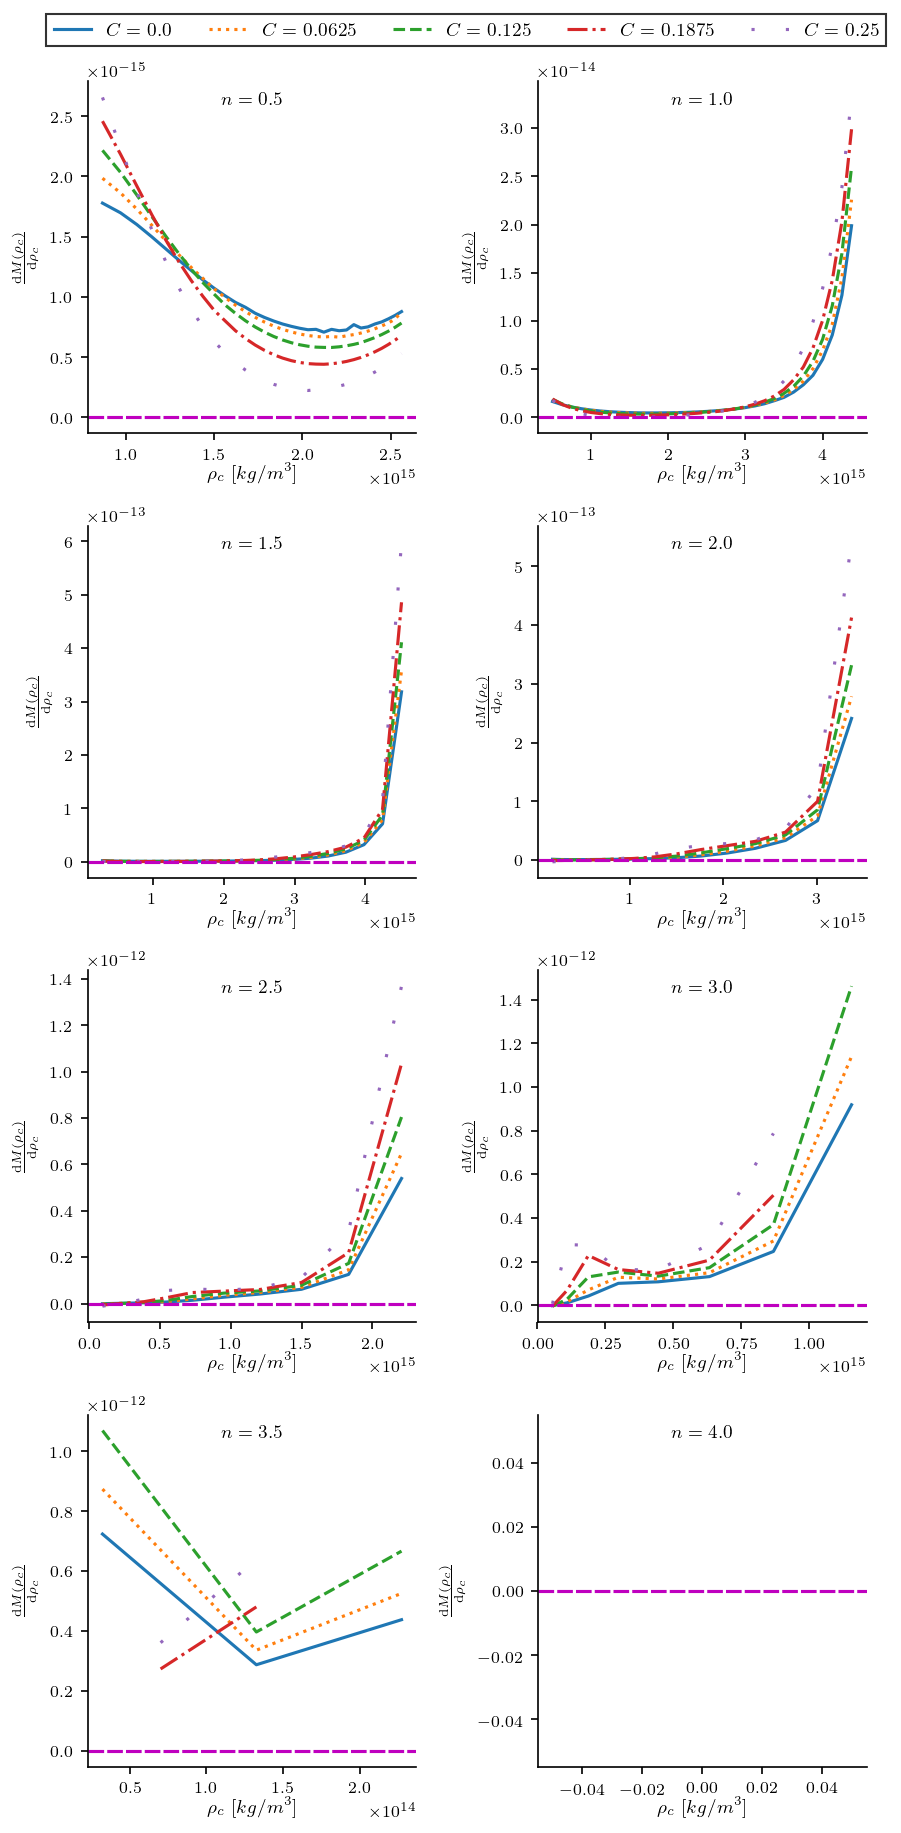

In [9]:
axes = ()
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(6,12),dpi=150)

for j in range(len(Lista_C)):
    
    dmdrho0 = diff(Lista_M[0][j])/diff(Lista_Rho_c[0][j])
    Lista_Rho_c0 = Lista_Rho_c[0][j][:-1]
    
    dmdrho1 = diff(Lista_M[1][j])/diff(Lista_Rho_c[1][j])
    Lista_Rho_c1 = Lista_Rho_c[1][j][:-1]
    
    dmdrho2 = diff(Lista_M[2][j])/diff(Lista_Rho_c[2][j])
    Lista_Rho_c2 = Lista_Rho_c[2][j][:-1]
    
    dmdrho3 = diff(Lista_M[3][j])/diff(Lista_Rho_c[3][j])
    Lista_Rho_c3 = Lista_Rho_c[3][j][:-1]
    
    dmdrho4 = diff(Lista_M[4][j])/diff(Lista_Rho_c[4][j])
    Lista_Rho_c4 = Lista_Rho_c[4][j][:-1]
    
    dmdrho5 = diff(Lista_M[5][j])/diff(Lista_Rho_c[5][j])
    Lista_Rho_c5 = Lista_Rho_c[5][j][:-1]
    
    dmdrho6 = diff(Lista_M[6][j])/diff(Lista_Rho_c[6][j])
    Lista_Rho_c6 = Lista_Rho_c[6][j][:-1]
    
    dmdrho7 = diff(Lista_M[7][j])/diff(Lista_Rho_c[7][j])
    Lista_Rho_c7 = Lista_Rho_c[7][j][:-1]
    
    
    axes[0][0].plot(Lista_Rho_c0,dmdrho0,linestyle=LineStyles[j],label=r'$C = {}$'.format(Lista_C[j]))
    axes[0][1].plot(Lista_Rho_c1,dmdrho1,linestyle=LineStyles[j])
    axes[1][0].plot(Lista_Rho_c2,dmdrho2,linestyle=LineStyles[j])
    axes[1][1].plot(Lista_Rho_c3,dmdrho3,linestyle=LineStyles[j])
    axes[2][0].plot(Lista_Rho_c4,dmdrho4,linestyle=LineStyles[j])
    axes[2][1].plot(Lista_Rho_c5,dmdrho5,linestyle=LineStyles[j])
    axes[3][0].plot(Lista_Rho_c6,dmdrho6,linestyle=LineStyles[j])
    axes[3][1].plot(Lista_Rho_c7,dmdrho7,linestyle=LineStyles[j])
    
    
axes[0][0].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[0][0].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[0][0].xaxis.set_label_coords(0.5,-0.0875)
axes[0][0].set_title(r'$n = %.1f$'%(Lista_n[0]),x=0.5,y=0.9,fontsize=9)
axes[0][0].spines['right'].set_color('none')
axes[0][0].spines['top'].set_color('none')
axes[0][0].axhline(y=0,color='m',linestyle=(0,(5,1)))
axes[0][0].legend(ncol=5, loc=(-0.125,1.1),fontsize=9,edgecolor='k',fancybox=False)

axes[0][1].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[0][1].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[0][1].xaxis.set_label_coords(0.5,-0.0875)
axes[0][1].set_title(r'$n = %.1f$'%(Lista_n[1]),x=0.5,y=0.9,fontsize=9)
axes[0][1].spines['right'].set_color('none')
axes[0][1].spines['top'].set_color('none')
axes[0][1].axhline(y=0,color='m',linestyle=(0,(5,1)))

axes[1][0].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[1][0].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[1][0].xaxis.set_label_coords(0.5,-0.0875)
axes[1][0].set_title(r'$n = %.1f$'%(Lista_n[2]),x=0.5,y=0.9,fontsize=9)
axes[1][0].spines['right'].set_color('none')
axes[1][0].spines['top'].set_color('none')
axes[1][0].axhline(y=0,color='m',linestyle=(0,(5,1)))

axes[1][1].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[1][1].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[1][1].xaxis.set_label_coords(0.5,-0.0875)
axes[1][1].set_title(r'$n = %.1f$'%(Lista_n[3]),x=0.5,y=0.9,fontsize=9)
axes[1][1].spines['right'].set_color('none')
axes[1][1].spines['top'].set_color('none')
axes[1][1].axhline(y=0,color='m',linestyle=(0,(5,1)))

axes[2][0].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[2][0].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[2][0].xaxis.set_label_coords(0.5,-0.0875)
axes[2][0].set_title(r'$n = %.1f$'%(Lista_n[4]),x=0.5,y=0.9,fontsize=9)
axes[2][0].spines['right'].set_color('none')
axes[2][0].spines['top'].set_color('none')
axes[2][0].axhline(y=0,color='m',linestyle=(0,(5,1)))

axes[2][1].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[2][1].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[2][1].xaxis.set_label_coords(0.5,-0.0875)
axes[2][1].set_title(r'$n = %.1f$'%(Lista_n[5]),x=0.5,y=0.9,fontsize=9)
axes[2][1].spines['right'].set_color('none')
axes[2][1].spines['top'].set_color('none')
axes[2][1].axhline(y=0,color='m',linestyle=(0,(5,1)))

axes[3][0].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[3][0].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[3][0].xaxis.set_label_coords(0.5,-0.0875)
axes[3][0].set_title(r'$n = %.1f$'%(Lista_n[6]),x=0.5,y=0.9,fontsize=9)
axes[3][0].spines['right'].set_color('none')
axes[3][0].spines['top'].set_color('none')
axes[3][0].axhline(y=0,color='m',linestyle=(0,(5,1)))

axes[3][1].set_xlabel(r'$\rho_c \, \, [kg/m^{3}]$',fontsize=9)
axes[3][1].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[3][1].xaxis.set_label_coords(0.5,-0.0875)
axes[3][1].set_title(r'$n = %.1f$'%(Lista_n[7]),x=0.5,y=0.9,fontsize=9)
axes[3][1].spines['right'].set_color('none')
axes[3][1].spines['top'].set_color('none')
axes[3][1].axhline(y=0,color='m',linestyle=(0,(5,1)))


fig.tight_layout()


plt.show()

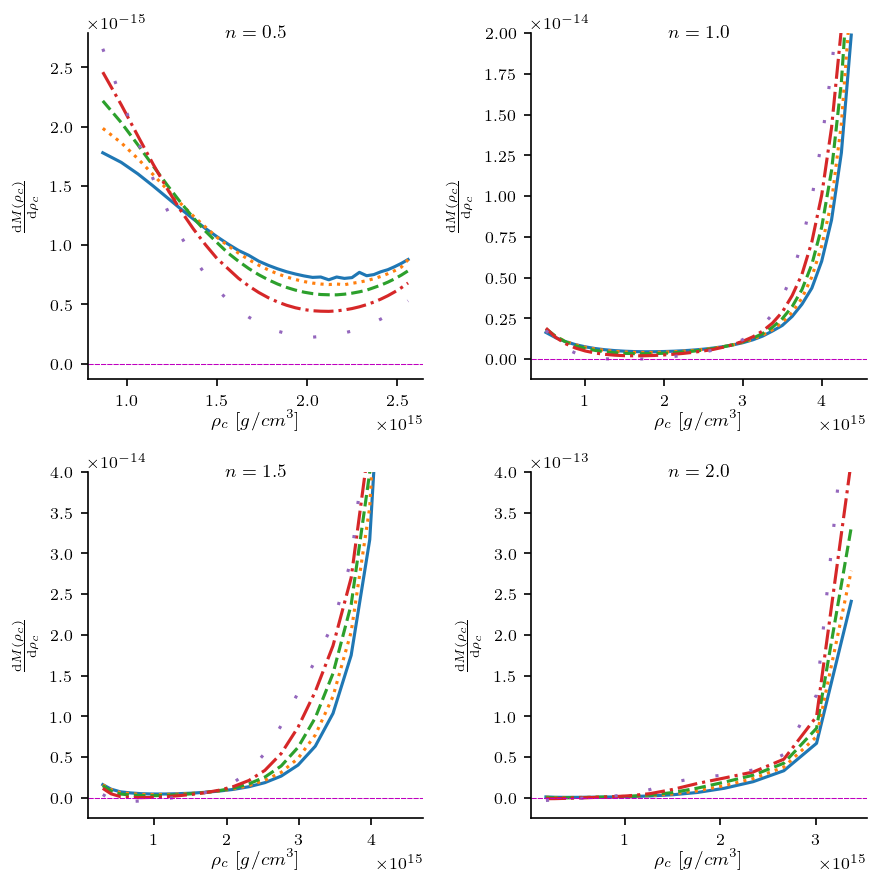

In [25]:
axes = ()
fig, axes = plt.subplots(nrows=2,ncols=2,sharex=False,figsize=(6,6),dpi=150)


for j in range(len(Lista_C)):
    
    dmdrho0 = diff(Lista_M[0][j])/diff(Lista_Rho_c[0][j])
    Lista_Rho_c0 = Lista_Rho_c[0][j][:-1]
    
    dmdrho1 = diff(Lista_M[1][j])/diff(Lista_Rho_c[1][j])
    Lista_Rho_c1 = Lista_Rho_c[1][j][:-1]
    
    dmdrho2 = diff(Lista_M[2][j])/diff(Lista_Rho_c[2][j])
    Lista_Rho_c2 = Lista_Rho_c[2][j][:-1]
    
    dmdrho3 = diff(Lista_M[3][j])/diff(Lista_Rho_c[3][j])
    Lista_Rho_c3 = Lista_Rho_c[3][j][:-1]
    
    
    axes[0][0].plot(Lista_Rho_c0,dmdrho0,linestyle=LineStyles[j])
    axes[0][1].plot(Lista_Rho_c1,dmdrho1,linestyle=LineStyles[j])
    axes[1][0].plot(Lista_Rho_c2,dmdrho2,linestyle=LineStyles[j])
    axes[1][1].plot(Lista_Rho_c3,dmdrho3,linestyle=LineStyles[j],label=r'$C = {}$'.format(Lista_C[j]))

    
axes[0][0].set_xlabel(r'$\rho_c \, \, [g/cm^{3}]$',fontsize=9)
axes[0][0].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[0][0].xaxis.set_label_coords(0.5,-0.09)
axes[0][0].set_title(r'$n = {}$'.format(Lista_n[0]),x=0.5,y=0.95,fontsize=9)
axes[0][0].spines['right'].set_color('none')
axes[0][0].spines['top'].set_color('none')
axes[0][0].axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

axes[0][1].set_xlabel(r'$\rho_c \, \, [g/cm^{3}]$',fontsize=9)
axes[0][1].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[0][1].set_ybound(-0.125*10**(-14),2*10**(-14))
axes[0][1].xaxis.set_label_coords(0.5,-0.09)
axes[0][1].set_title(r'$n = %.1f$'%(Lista_n[1]),x=0.5,y=0.95,fontsize=9)
axes[0][1].spines['right'].set_color('none')
axes[0][1].spines['top'].set_color('none')
axes[0][1].axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

axes[1][0].set_xlabel(r'$\rho_c \, \, [g/cm^{3}]$',fontsize=9)
axes[1][0].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[1][0].set_ybound(-0.25*10**(-14),4*10**(-14))
axes[1][0].xaxis.set_label_coords(0.5,-0.09)
axes[1][0].set_title(r'$n = %.1f$'%(Lista_n[2]),x=0.5,y=0.95,fontsize=9)
axes[1][0].spines['right'].set_color('none')
axes[1][0].spines['top'].set_color('none')
axes[1][0].axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

axes[1][1].set_xlabel(r'$\rho_c \, \, [g/cm^{3}]$',fontsize=9)
axes[1][1].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[1][1].set_ybound(-0.25*10**(-13),4*10**(-13))
axes[1][1].xaxis.set_label_coords(0.5,-0.09)
axes[1][1].set_title(r'$n = %.1f$'%(Lista_n[3]),x=0.5,y=0.95,fontsize=9)
axes[1][1].spines['right'].set_color('none')
axes[1][1].spines['top'].set_color('none')
axes[1][1].axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)
# axes[1][1].legend(ncol=5, loc=(-1.465,-0.3),fontsize=9,edgecolor='k',fancybox=False)

# axes[1][0].set_xbound(6.5*10**(17),4*10**(19))


    

fig.tight_layout()


plt.show()


In [11]:
print(min(Lista_Rho_c0),max(Lista_Rho_c0))
print(min(Lista_Rho_c1),max(Lista_Rho_c1))
print(min(Lista_Rho_c2),max(Lista_Rho_c2))
print(min(Lista_Rho_c3),max(Lista_Rho_c3))

print(min(dmdrho0),max(dmdrho0))
print(min(dmdrho1),max(dmdrho1))
print(min(dmdrho2),max(dmdrho2))
print(min(dmdrho3),max(dmdrho3))


866025403784438.6 2561737691489899.5
499999999999999.94 4374999999999999.5
288675134594812.3 4510548978043942.0
166666666666666.72 3375000000000002.5
2.2358607168453325e-16 2.6559417586497585e-15
-1.8880721749372536e-17 3.3188900667193567e-14
-4.524492647208096e-16 5.993680038042379e-13
-3.2378107881634043e-15 5.419603978399977e-13


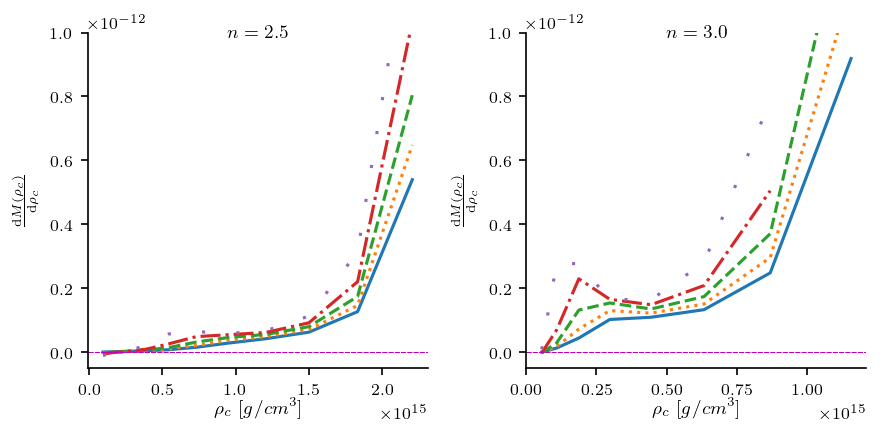

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6,3),dpi=150)


for j in range(len(Lista_C)):
    
    dmdrho4 = diff(Lista_M[4][j])/diff(Lista_Rho_c[4][j])
    Lista_Rho_c4 = Lista_Rho_c[4][j][:-1]
    
    dmdrho5 = diff(Lista_M[5][j])/diff(Lista_Rho_c[5][j])
    Lista_Rho_c5 = Lista_Rho_c[5][j][:-1]    
    
    ax1.plot(Lista_Rho_c4,dmdrho4,linestyle=LineStyles[j],label=r'$C = {}$'.format(Lista_C[j]))
    ax2.plot(Lista_Rho_c5,dmdrho5,linestyle=LineStyles[j])
   
    
ax1.set_xlabel(r'$\rho_c \, \, [g/cm^{3}]$',fontsize=9)
ax1.set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
ax1.set_ybound(-0.5*10**(-13),1*10**(-12))
ax1.xaxis.set_label_coords(0.5,-0.09)
ax1.set_title(r'$n = %.1f$'%(Lista_n[4]),x=0.5,y=0.95,fontsize=9)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)
# ax1.legend(ncol=5, loc=(-0.125,1.1),fontsize=9,edgecolor='k',fancybox=False)


ax2.set_xlabel(r'$\rho_c \, \, [g/cm^{3}]$',fontsize=9)
ax2.set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
ax2.set_ybound(-0.5*10**(-13),1*10**(-12))
ax2.xaxis.set_label_coords(0.5,-0.09)
ax2.set_title(r'$n = %.1f$'%(Lista_n[5]),x=0.5,y=0.95,fontsize=9)
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.tight_layout()

plt.show()


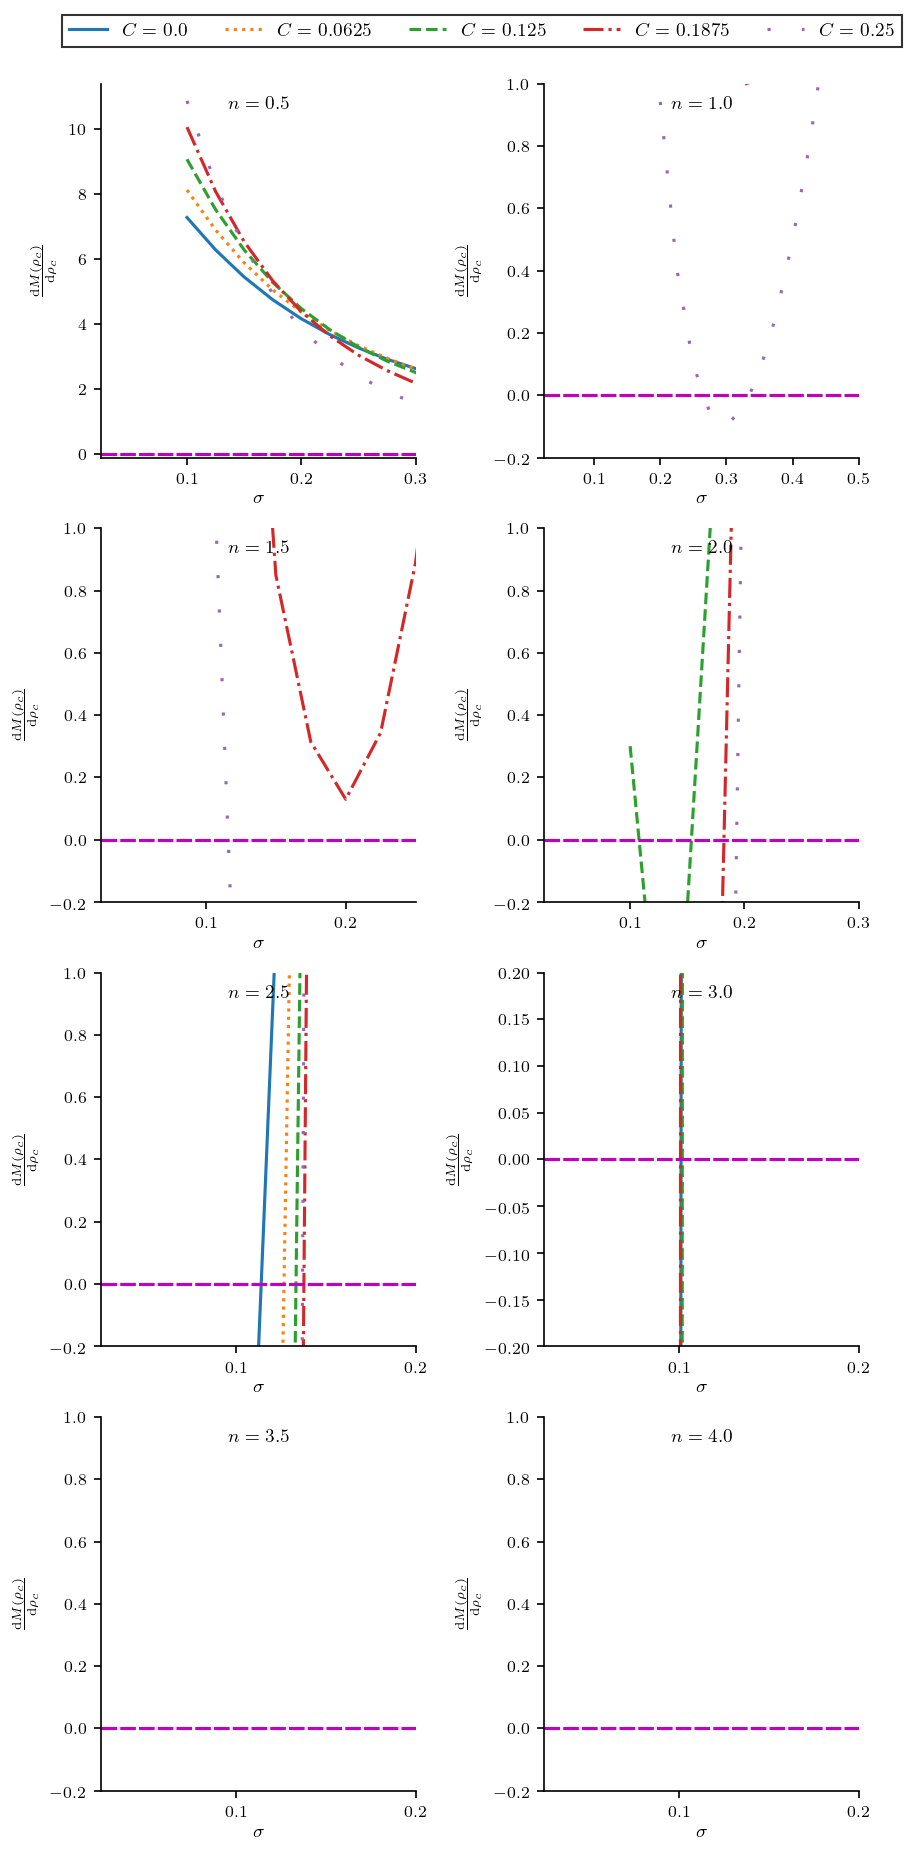

In [13]:
axes = ()
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(6,12),dpi=150)

for j in range(len(Lista_C)):
    
    dmdrho0 = diff(Lista_M[0][j])/diff(Lista_sigma_m[0][j])
    Lista_sigma_m0 = Lista_sigma_m[0][j][:-1]
    
    dmdrho1 = diff(Lista_M[1][j])/diff(Lista_sigma_m[1][j])
    Lista_sigma_m1 = Lista_sigma_m[1][j][:-1]
    
    dmdrho2 = diff(Lista_M[2][j])/diff(Lista_sigma_m[2][j])
    Lista_sigma_m2 = Lista_sigma_m[2][j][:-1]
    
    dmdrho3 = diff(Lista_M[3][j])/diff(Lista_sigma_m[3][j])
    Lista_sigma_m3 = Lista_sigma_m[3][j][:-1]
    
    dmdrho4 = diff(Lista_M[4][j])/diff(Lista_sigma_m[4][j])
    Lista_sigma_m4 = Lista_sigma_m[4][j][:-1]
    
    dmdrho5 = diff(Lista_M[5][j])/diff(Lista_sigma_m[5][j])
    Lista_sigma_m5 = Lista_sigma_m[5][j][:-1]
    
    dmdrho6 = diff(Lista_M[6][j])/diff(Lista_sigma_m[6][j])
    Lista_sigma_m6 = Lista_sigma_m[6][j][:-1]
    
    dmdrho7 = diff(Lista_M[7][j])/diff(Lista_sigma_m[7][j])
    Lista_sigma_m7 = Lista_sigma_m[7][j][:-1]
    
    
    axes[0][0].plot(Lista_sigma_m0,dmdrho0,linestyle=LineStyles[j],label=r'$C = {}$'.format(Lista_C[j]))
    axes[0][1].plot(Lista_sigma_m1,dmdrho1,linestyle=LineStyles[j])
    axes[1][0].plot(Lista_sigma_m2,dmdrho2,linestyle=LineStyles[j])
    axes[1][1].plot(Lista_sigma_m3,dmdrho3,linestyle=LineStyles[j])
    axes[2][0].plot(Lista_sigma_m4,dmdrho4,linestyle=LineStyles[j])
    axes[2][1].plot(Lista_sigma_m5,dmdrho5,linestyle=LineStyles[j])
    axes[3][0].plot(Lista_sigma_m6,dmdrho6,linestyle=LineStyles[j])
    axes[3][1].plot(Lista_sigma_m7,dmdrho7,linestyle=LineStyles[j])
    

axes[0][0].set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
axes[0][0].set_xlabel(r'$\sigma$',fontsize=9)
axes[0][0].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[0][0].set_xbound(0.025,0.3)
axes[0][0].xaxis.set_label_coords(0.5,-0.0875)
axes[0][0].set_title(r'$n = %.1f$'%(Lista_n[0]),x=0.5,y=0.9,fontsize=9)
axes[0][0].spines['right'].set_color('none')
axes[0][0].spines['top'].set_color('none')
axes[0][0].axhline(y=0,color='m',linestyle=(0,(5,1)))
axes[0][0].legend(ncol=5, loc=(-0.125,1.1),fontsize=9,edgecolor='k',fancybox=False)

axes[0][1].set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
axes[0][1].set_xlabel(r'$\sigma$',fontsize=9)
axes[0][1].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[0][1].set_xbound(0.025,0.5)
axes[0][1].set_ybound(-0.2,1.0)
axes[0][1].xaxis.set_label_coords(0.5,-0.0875)
axes[0][1].set_title(r'$n = %.1f$'%(Lista_n[1]),x=0.5,y=0.9,fontsize=9)
axes[0][1].spines['right'].set_color('none')
axes[0][1].spines['top'].set_color('none')
axes[0][1].axhline(y=0,color='m',linestyle=(0,(5,1)))

axes[1][0].set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
axes[1][0].set_xlabel(r'$\sigma$',fontsize=9)
axes[1][0].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[1][0].set_xbound(0.025,0.25)
axes[1][0].set_ybound(-0.2,1.0)
axes[1][0].xaxis.set_label_coords(0.5,-0.0875)
axes[1][0].set_title(r'$n = %.1f$'%(Lista_n[2]),x=0.5,y=0.9,fontsize=9)
axes[1][0].spines['right'].set_color('none')
axes[1][0].spines['top'].set_color('none')
axes[1][0].axhline(y=0,color='m',linestyle=(0,(5,1)))

axes[1][1].set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
axes[1][1].set_xlabel(r'$\sigma$',fontsize=9)
axes[1][1].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[1][1].set_ybound(-0.2,1.0)
axes[1][1].set_xbound(0.025,0.3)
# axes[1][1].set_ybound(-2.0*10**(-19),0.5*10**(-19))
axes[1][1].xaxis.set_label_coords(0.5,-0.0875)
axes[1][1].set_title(r'$n = %.1f$'%(Lista_n[3]),x=0.5,y=0.9,fontsize=9)
axes[1][1].spines['right'].set_color('none')
axes[1][1].spines['top'].set_color('none')
axes[1][1].axhline(y=0,color='m',linestyle=(0,(5,1)))

axes[2][0].set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
axes[2][0].set_xlabel(r'$\sigma$',fontsize=9)
axes[2][0].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[2][0].set_ybound(-0.2,1.0)
axes[2][0].set_xbound(0.025,0.2)
# axes[2][0].set_ybound(-2.5*10**(-19),0.5*10**(-19))
axes[2][0].xaxis.set_label_coords(0.5,-0.0875)
axes[2][0].set_title(r'$n = %.1f$'%(Lista_n[4]),x=0.5,y=0.9,fontsize=9)
axes[2][0].spines['right'].set_color('none')
axes[2][0].spines['top'].set_color('none')
axes[2][0].axhline(y=0,color='m',linestyle=(0,(5,1)))

axes[2][1].set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
axes[2][1].set_xlabel(r'$\sigma$',fontsize=9)
axes[2][1].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[2][1].set_xbound(0.025,0.2)
axes[2][1].set_ybound(-0.2,0.2)
# axes[2][1].set_ybound(-3.0*10**(-19),0.5*10**(-19))
axes[2][1].xaxis.set_label_coords(0.5,-0.0875)
axes[2][1].set_title(r'$n = %.1f$'%(Lista_n[5]),x=0.5,y=0.9,fontsize=9)
axes[2][1].spines['right'].set_color('none')
axes[2][1].spines['top'].set_color('none')
axes[2][1].axhline(y=0,color='m',linestyle=(0,(5,1)))

axes[3][0].set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
axes[3][0].set_xlabel(r'$\sigma$',fontsize=9)
axes[3][0].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[3][0].set_xbound(0.025,0.2)
axes[3][0].set_ybound(-0.2,1.0)
# axes[3][0].set_ybound(-4.0*10**(-19),0.5*10**(-19))
axes[3][0].xaxis.set_label_coords(0.5,-0.0875)
axes[3][0].set_title(r'$n = %.1f$'%(Lista_n[6]),x=0.5,y=0.9,fontsize=9)
axes[3][0].spines['right'].set_color('none')
axes[3][0].spines['top'].set_color('none')
axes[3][0].axhline(y=0,color='m',linestyle=(0,(5,1)))

axes[3][1].set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
axes[3][1].set_xlabel(r'$\sigma$',fontsize=9)
axes[3][1].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[3][1].set_xbound(0.025,0.2)
axes[3][1].set_ybound(-0.2,1.0)
# axes[3][1].set_ybound(-4.0*10**(-19),0.5*10**(-19))
axes[3][1].xaxis.set_label_coords(0.5,-0.0875)
axes[3][1].set_title(r'$n = %.1f$'%(Lista_n[7]),x=0.5,y=0.9,fontsize=9)
axes[3][1].spines['right'].set_color('none')
axes[3][1].spines['top'].set_color('none')
axes[3][1].axhline(y=0,color='m',linestyle=(0,(5,1)))


fig.tight_layout()


plt.show()

In [14]:
Lista_dmdrho = []

for i in range(len(Lista_n)):
    
    Lista_dmdrho.append([])
    
    for j in range(len(Lista_C)):
                
        dmdrho = diff(Lista_M[i][j])/diff(Lista_sigma_m[i][j])
        
        Lista_dmdrho[i].append(dmdrho)
        
        
for i in range(len(Lista_n)-2):
        
    for j in range(len(Lista_C)):
        
        lim = np.where(np.diff(np.sign(Lista_dmdrho[i][j])) != 0)
        
        if len(lim[0]) == 0:
            
            if np.sign(Lista_dmdrho[i][j][len(Lista_dmdrho[i][j])//2]) == 1:
                
                print('n = {}, '.format(Lista_n[i]), 'C = {} ,'.format(Lista_C[j]), 'Todos los sigmas son válidos')
            
            else:
                
                print('n = {}, '.format(Lista_n[i]), 'C = {} ,'.format(Lista_C[j]), 'Ninguno de los sigmas es válido')
        
        elif len(lim[0]) == 1:
            
            print('n = {}, '.format(Lista_n[i]), 'C = {} ,'.format(Lista_C[j]), 'sigma límite = {}'.format(Lista_sigma_m[i][j][lim[0][0]]))
        
        else:
            print('n = {}, '.format(Lista_n[i]), 'C = {} ,'.format(Lista_C[j]), 'sigma límite 1 = {}, '.format(Lista_sigma_m[i][j][lim[0][0]]),
                  'sigma límite 2 = {}'.format(Lista_sigma_m[i][j][lim[0][1]]))

n = 0.5,  C = 0.0 , Todos los sigmas son válidos
n = 0.5,  C = 0.0625 , Todos los sigmas son válidos
n = 0.5,  C = 0.125 , Todos los sigmas son válidos
n = 0.5,  C = 0.1875 , Todos los sigmas son válidos
n = 0.5,  C = 0.25 , Todos los sigmas son válidos
n = 1.0,  C = 0.0 , Todos los sigmas son válidos
n = 1.0,  C = 0.0625 , Todos los sigmas son válidos
n = 1.0,  C = 0.125 , Todos los sigmas son válidos
n = 1.0,  C = 0.1875 , Todos los sigmas son válidos
n = 1.0,  C = 0.25 , sigma límite 1 = 0.25,  sigma límite 2 = 0.325
n = 1.5,  C = 0.0 , Todos los sigmas son válidos
n = 1.5,  C = 0.0625 , Todos los sigmas son válidos
n = 1.5,  C = 0.125 , Todos los sigmas son válidos
n = 1.5,  C = 0.1875 , Todos los sigmas son válidos
n = 1.5,  C = 0.25 , sigma límite 1 = 0.1,  sigma límite 2 = 0.25
n = 2.0,  C = 0.0 , Todos los sigmas son válidos
n = 2.0,  C = 0.0625 , Todos los sigmas son válidos
n = 2.0,  C = 0.125 , sigma límite 1 = 0.1,  sigma límite 2 = 0.15000000000000002
n = 2.0,  C = 0.1875 

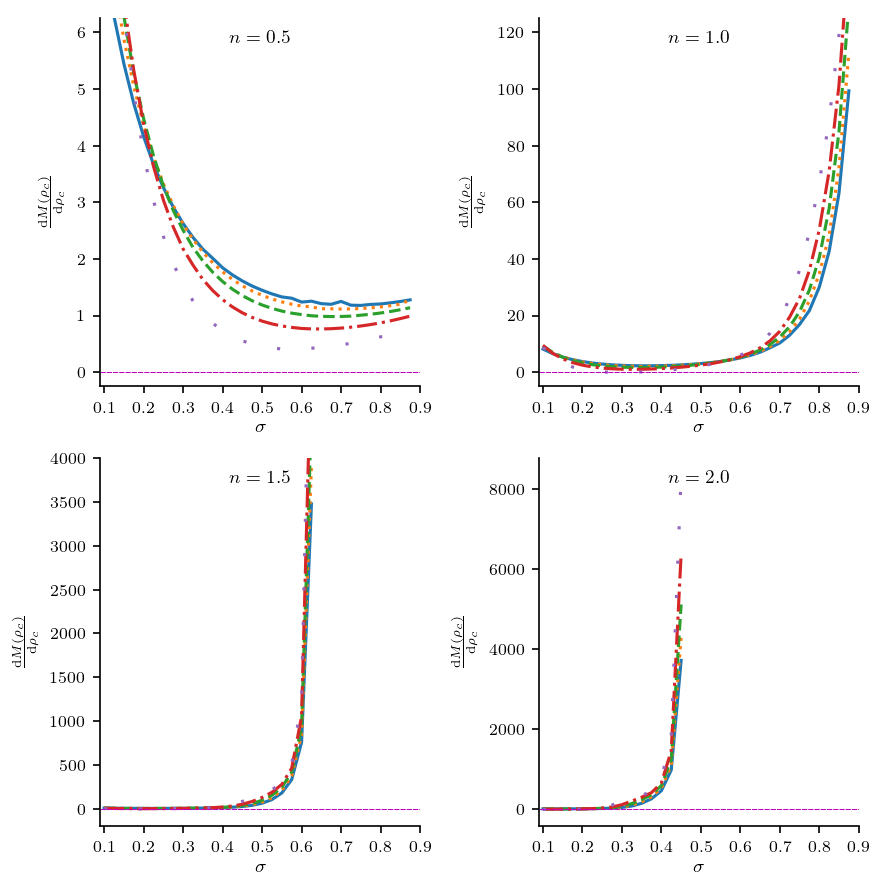

In [37]:
axes = ()
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(6,6),dpi=150)

for j in range(len(Lista_C)):
    
    dmdrho0 = diff(Lista_M[0][j])/diff(Lista_sigma_m[0][j])
    Lista_sigma_m0 = Lista_sigma_m[0][j][:-1]
    
    dmdrho1 = diff(Lista_M[1][j])/diff(Lista_sigma_m[1][j])
    Lista_sigma_m1 = Lista_sigma_m[1][j][:-1]
    
    dmdrho2 = diff(Lista_M[2][j])/diff(Lista_sigma_m[2][j])
    Lista_sigma_m2 = Lista_sigma_m[2][j][:-1]
    
    dmdrho3 = diff(Lista_M[3][j])/diff(Lista_sigma_m[3][j])
    Lista_sigma_m3 = Lista_sigma_m[3][j][:-1]
    
    
    axes[0][0].plot(Lista_sigma_m0,dmdrho0,linestyle=LineStyles[j],label=r'$C = {}$'.format(Lista_C[j]))
    axes[0][1].plot(Lista_sigma_m1,dmdrho1,linestyle=LineStyles[j])
    axes[1][0].plot(Lista_sigma_m2,dmdrho2,linestyle=LineStyles[j])
    axes[1][1].plot(Lista_sigma_m3,dmdrho3,linestyle=LineStyles[j])
    

axes[0][0].set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
axes[0][0].set_xlabel(r'$\sigma$',fontsize=9)
axes[0][0].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[0][0].set_xbound(0.09,0.9)
axes[0][0].set_ybound(-0.25,6.25)
axes[0][0].xaxis.set_label_coords(0.5,-0.0875)
axes[0][0].set_title(r'$n = %.1f$'%(Lista_n[0]),x=0.5,y=0.9,fontsize=9)
axes[0][0].spines['right'].set_color('none')
axes[0][0].spines['top'].set_color('none')
axes[0][0].axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)
# axes[0][0].legend(ncol=5, loc=(-0.125,1.1),fontsize=9,edgecolor='k',fancybox=False)

axes[0][1].set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
axes[0][1].set_xlabel(r'$\sigma$',fontsize=9)
axes[0][1].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[0][1].set_xbound(0.09,0.9)
axes[0][1].set_ybound(-5,125.0)
axes[0][1].xaxis.set_label_coords(0.5,-0.0875)
axes[0][1].set_title(r'$n = %.1f$'%(Lista_n[1]),x=0.5,y=0.9,fontsize=9)
axes[0][1].spines['right'].set_color('none')
axes[0][1].spines['top'].set_color('none')
axes[0][1].axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

axes[1][0].set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
axes[1][0].set_xlabel(r'$\sigma$',fontsize=9)
axes[1][0].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
axes[1][0].set_xbound(0.09,0.9)
axes[1][0].set_ybound(-200,4000.0)
axes[1][0].xaxis.set_label_coords(0.5,-0.0875)
axes[1][0].set_title(r'$n = %.1f$'%(Lista_n[2]),x=0.5,y=0.9,fontsize=9)
axes[1][0].spines['right'].set_color('none')
axes[1][0].spines['top'].set_color('none')
axes[1][0].axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

axes[1][1].set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
axes[1][1].set_xlabel(r'$\sigma$',fontsize=9)
axes[1][1].set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
# axes[1][1].set_ybound(-0.2,1.0)
axes[1][1].set_xbound(0.09,0.9)
axes[1][1].xaxis.set_label_coords(0.5,-0.0875)
axes[1][1].set_title(r'$n = %.1f$'%(Lista_n[3]),x=0.5,y=0.9,fontsize=9)
axes[1][1].spines['right'].set_color('none')
axes[1][1].spines['top'].set_color('none')
axes[1][1].axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)


fig.tight_layout()


plt.show()

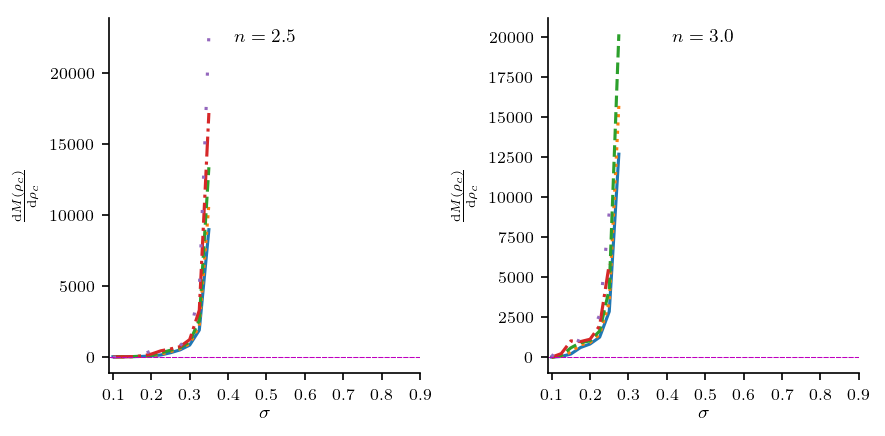

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6,3),dpi=150)

for j in range(len(Lista_C)):
    
    dmdrho4 = diff(Lista_M[4][j])/diff(Lista_sigma_m[4][j])
    Lista_sigma_m4 = Lista_sigma_m[4][j][:-1]
    
    dmdrho5 = diff(Lista_M[5][j])/diff(Lista_sigma_m[5][j])
    Lista_sigma_m5 = Lista_sigma_m[5][j][:-1]

    ax1.plot(Lista_sigma_m4,dmdrho4,linestyle=LineStyles[j],label=r'$C = {}$'.format(Lista_C[j]))
    ax2.plot(Lista_sigma_m5,dmdrho5,linestyle=LineStyles[j])
    

ax1.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ax1.set_xlabel(r'$\sigma$',fontsize=9)
ax1.set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
ax1.set_xbound(0.09,0.9)
ax1.xaxis.set_label_coords(0.5,-0.0875)
ax1.set_title(r'$n = %.1f$'%(Lista_n[4]),x=0.5,y=0.9,fontsize=9)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)
# ax1.legend(ncol=5, loc=(-0.125,1.1),fontsize=9,edgecolor='k',fancybox=False)

ax2.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ax2.set_xlabel(r'$\sigma$',fontsize=9)
ax2.set_ylabel(r'$\frac{\mathrm{d}M(\rho_c)}{\mathrm{d}\rho_c}$',fontsize=9)
ax2.set_xbound(0.09,0.9)
ax2.xaxis.set_label_coords(0.5,-0.0875)
ax2.set_title(r'$n = %.1f$'%(Lista_n[5]),x=0.5,y=0.9,fontsize=9)
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.tight_layout()

plt.show()